# Imports

In [1]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main
#!sudo apt-get install -y libsndfile1-dev
!pip3 install -q SoundFile
%matplotlib inline 
!pip3 install librosa

In [2]:
import os

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.metrics import Recall, Accuracy
from tensorflow.keras.activations import tanh
from wav2vec2 import Wav2Vec2Config

from tensorflow.python.keras.callbacks import EarlyStopping

import numpy as np

import soundfile as sf

from IPython.display import Audio, display
import random

from wav2vec2 import Wav2Vec2Processor

import matplotlib.pyplot as plt

import librosa
from random import randint, choice

print("TF version:", tf.__version__)

TF version: 2.8.0


# Hyper Params

In [3]:
classes = ['fru', 'ang', 'sad', 'hap']

model_folder = "models"

experiment_name = "wav2vec2_trainable"

AUDIO_MAXLEN = 246000 # to mimic the artical original is 246000
LABEL_MAXLEN = 4
BATCH_SIZE =  8 # artical is 32



# Data Functions

In [4]:
data_dir = "../Data/Audio/"
sessions_dir = [data_dir + "/Ses01", data_dir + "/Ses02", data_dir + "/Ses03", data_dir + "/Ses04", data_dir + "/Ses05"]


In [5]:
REQUIRED_SAMPLE_RATE = 16000

def read_wav_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return {file_id: audio}

def change_pitch(data,sample_rate, pitch_factor=0, random_pitch = False):
    if random_pitch:
        pitch_factor = randint(-1,1)
    return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)

In [6]:
def get_label(wav_file):
    label = wav_file.split("-")[-1].split(".")[0]
    if label == "exc":
        label = "hap"
    return label

def get_label_vec(label):
    label_vec = np.zeros(len(classes))
    label_vec[classes.index(label)] = 1
    return label_vec

def calc_data_len(dataset, batch_size = 1):
    count = 0
    for batch in dataset:
        count += 1
    return count * batch_size

def calc_distribution(labels, classes, data_name = ""):
    counter = {}
    for i in range(len(classes)):
        counter[i] = 0
    for x,label in labels:
        idx = np.argmax(label, axis=-1)
        counter[idx] += 1
    res = f"{data_name} Data Has {len(labels)} Samples: "
    for classIdx in counter:
        res += f"Class {classes[classIdx]} has {counter[classIdx]} samples"
        if classIdx == len(classes) - 1:
            res += "."
        else:
            res += ", "
    print(res + "\n")
    return counter

In [7]:
processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))

In [8]:
def fetch_sound_label_list(data_dir):
  all_files = os.listdir(data_dir)

  wav_files = [os.path.join(data_dir, f) for f in all_files if f.endswith(".wav")]
  
  speech_samples = {}
  for f in wav_files:
    speech_samples.update(read_wav_file(f))


  samples = [(speech_samples[file_id], get_label_vec(get_label(file_id))) for file_id in speech_samples.keys() if len(speech_samples[file_id]) < AUDIO_MAXLEN]
  return samples

In [9]:
def get_dataset(data_dir, random_pitch = False):
    samples = fetch_sound_label_list(data_dir)
    
    if random_pitch:
        def inputs_generator():
            for speech, label in samples:
                yield preprocess_speech(change_pitch(speech,REQUIRED_SAMPLE_RATE,random_pitch=True)), label
    else:
        def inputs_generator():
            for speech, label in samples:
                yield preprocess_speech(speech), label

    output_signature = (
        tf.TensorSpec(shape=(None),  dtype=tf.float32),
        tf.TensorSpec(shape=(len(classes),), dtype=tf.float32)
        )

    dataset = tf.data.Dataset.from_generator(inputs_generator, output_signature=output_signature)
    BUFFER_SIZE = len(samples)
    SEED = 42
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(AUDIO_MAXLEN, LABEL_MAXLEN), padding_values=(0.0, 0.0)).prefetch(tf.data.AUTOTUNE)
    counter = calc_distribution(samples, classes, data_name=data_dir.split("/")[-1])
    return dataset , counter


# Evaluation Functions

In [10]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
classes = ["fru","ang","sad","hap"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate_model(model, dataset):
    y_pred = []
    y_true = []
    correct = 0
    count = 0
    for x,y in dataset:
        pred = model.predict(x=x, verbose=0)
        y = y.numpy()
        pred = np.argmax(pred, axis=-1)
        y = np.argmax(y, axis=-1)
        assert len(pred) == len(y)
        batch_len = len(pred)
        for i in range(batch_len):
            if y[i] == pred[i]:
                correct += 1
            y_pred.append(pred[i])
            y_true.append(y[i])
        count += batch_len
        


    acc = float(correct / count)
    acc = format(acc, ".3f")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    #recall = recall_score(y_true=y_true, y_pred=y_pred, labels=[0,1,2,3], average='micro')
    #recall = format(recall, ".3f")
    plot_confusion_matrix(cm=cm, classes=classes, title=f"Confusion Matrix {acc}% Accuracy")

# Loading Data

In [11]:
sessions = []
pitched_sessions = []

for ses_dir in sessions_dir:
    ds , dist = get_dataset(ses_dir)
    sessions.append(ds)

    ds , dist = get_dataset(ses_dir, random_pitch=True)
    pitched_sessions.append(ds)
    

Ses01 Data Has 965 Samples: Class fru has 280 samples, Class ang has 225 samples, Class sad has 186 samples, Class hap has 274 samples.

Ses01 Data Has 965 Samples: Class fru has 280 samples, Class ang has 225 samples, Class sad has 186 samples, Class hap has 274 samples.

Ses02 Data Has 975 Samples: Class fru has 322 samples, Class ang has 137 samples, Class sad has 190 samples, Class hap has 326 samples.

Ses02 Data Has 975 Samples: Class fru has 322 samples, Class ang has 137 samples, Class sad has 190 samples, Class hap has 326 samples.

Ses03 Data Has 1209 Samples: Class fru has 382 samples, Class ang has 239 samples, Class sad has 304 samples, Class hap has 284 samples.

Ses03 Data Has 1209 Samples: Class fru has 382 samples, Class ang has 239 samples, Class sad has 304 samples, Class hap has 284 samples.

Ses04 Data Has 1244 Samples: Class fru has 479 samples, Class ang has 325 samples, Class sad has 139 samples, Class hap has 301 samples.

Ses04 Data Has 1244 Samples: Class fru

# Display Pitched Audio

In [12]:
audio = read_wav_file(data_dir+"/Ses03/Ses03F_impro07_M014-exc.wav")["Ses03F_impro07_M014-exc"]

for i in range(-4,5):
    print(f"\n\nPitched {i} audio file")
    tmp = change_pitch(audio,REQUIRED_SAMPLE_RATE,i)
    display(Audio(data=tmp, autoplay=True, rate=REQUIRED_SAMPLE_RATE))



Pitched -4 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-4 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched -3 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-3 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched -2 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-2 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched -1 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched 0 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched 1 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched 2 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=2 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched 3 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=3 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)




Pitched 4 audio file


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=4 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


# Testing 1

-----------------------------------Testing on 1 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[102  60  64  54]
 [ 44 138  15  28]
 [  9   1 175   1]
 [ 26  12  51 185]]


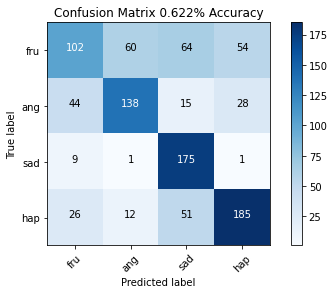



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[105  30  87  58]
 [ 70  88  17  50]
 [  7   0 178   1]
 [ 36   8  61 169]]


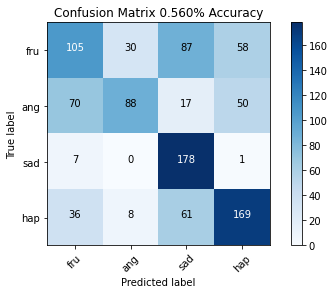

-----------------------------------Testing on 2 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[170  48  26  78]
 [ 37  85   1  14]
 [ 28   0 134  28]
 [ 70  27  20 209]]


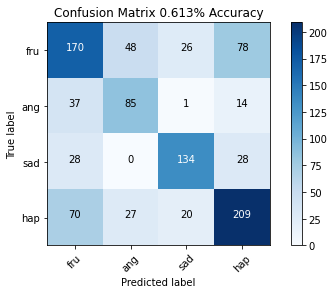



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[140  19  36 127]
 [ 51  41   6  39]
 [ 29   1 129  31]
 [ 77  10  31 208]]


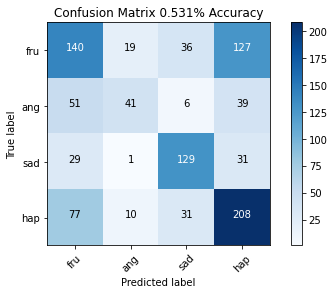

-----------------------------------Testing on 3 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[198  81  43  60]
 [ 88 111   6  34]
 [ 42   4 240  18]
 [ 74  14  78 118]]


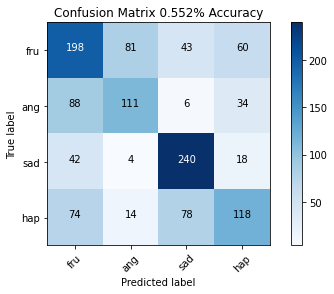



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[179  38  62 103]
 [ 91  61  10  77]
 [ 28   1 263  12]
 [ 70   5  87 122]]


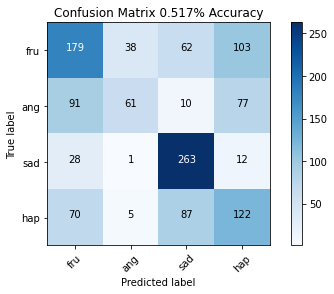

-----------------------------------Testing on 4 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[279 129  28  43]
 [ 88 226   0  11]
 [ 37   4  92   6]
 [ 93  64  21 123]]


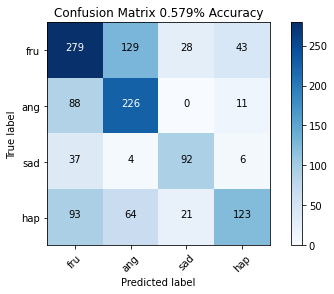



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[268  67  64  80]
 [185 100   6  34]
 [ 24   1 102  12]
 [109  30  30 132]]


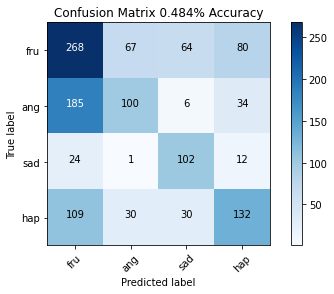

-----------------------------------Testing on 5 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[209  64  33  68]
 [ 66  78   7  17]
 [ 30   1 165  42]
 [105  16  50 263]]


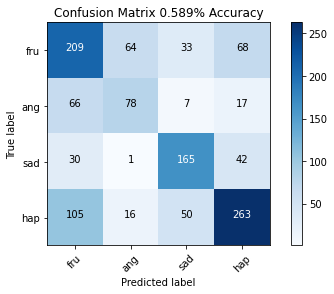



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[167  21  77 109]
 [ 59  33  16  60]
 [ 21   1 177  39]
 [ 92   5  69 268]]


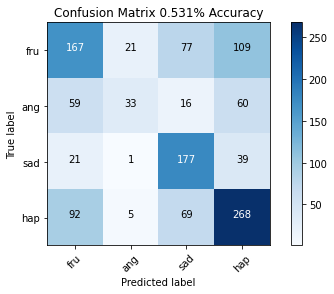

In [13]:
for ses_idx in range(0,5):
    try:
        print(f"-----------------------------------Testing on {ses_idx + 1} fold-----------------------------------")
        val_set = sessions[ses_idx]
        val_pitched_set = pitched_sessions[ses_idx]
        model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
        model = tf.keras.models.load_model(f"{model_folder}/{model_name}")
        print("\n\nNormal Fold:")
        evaluate_model(model, val_set)
        print("\n\nPitched Fold:")
        evaluate_model(model, val_pitched_set)
    except Exception as e:
        print(e)

# Testing 2

-----------------------------------Testing on 1 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[102  60  64  54]
 [ 44 138  15  28]
 [  9   1 175   1]
 [ 26  12  51 185]]


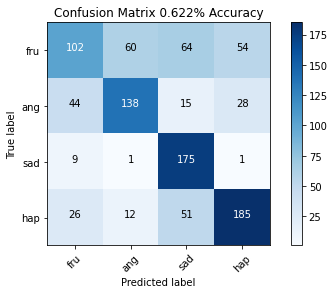



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[112  23  88  57]
 [ 79  76  20  50]
 [  8   1 175   2]
 [ 43   7  59 165]]


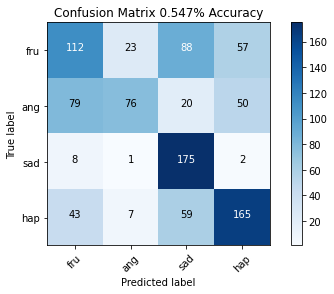

-----------------------------------Testing on 2 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[170  48  26  78]
 [ 37  85   1  14]
 [ 28   0 134  28]
 [ 70  27  20 209]]


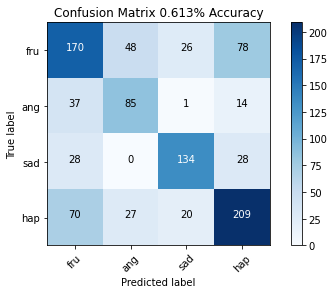



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[145  25  37 115]
 [ 46  47   4  40]
 [ 23   0 133  34]
 [ 86  13  30 197]]


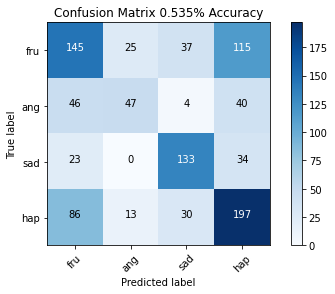

-----------------------------------Testing on 3 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[198  81  43  60]
 [ 88 111   6  34]
 [ 42   4 240  18]
 [ 74  14  78 118]]


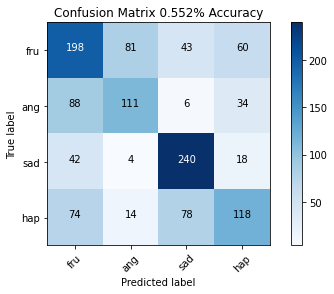



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[174  31  61 116]
 [ 98  56  12  73]
 [ 35   1 257  11]
 [ 68   7  90 119]]


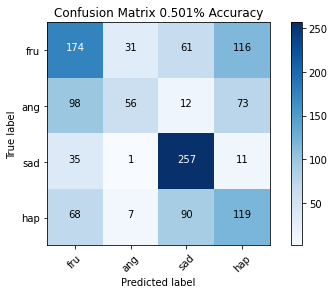

-----------------------------------Testing on 4 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[279 129  28  43]
 [ 88 226   0  11]
 [ 37   4  92   6]
 [ 93  64  21 123]]


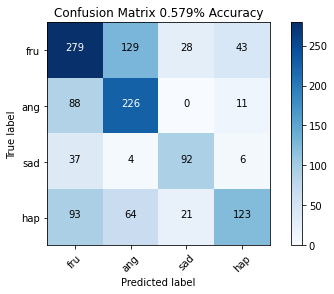



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[283  59  60  77]
 [173 109   9  34]
 [ 22   3 105   9]
 [101  33  35 132]]


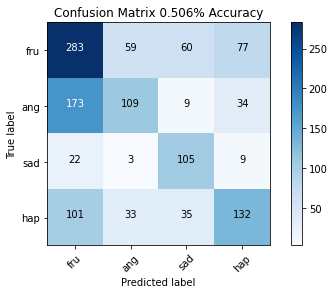

-----------------------------------Testing on 5 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[209  64  33  68]
 [ 66  78   7  17]
 [ 30   1 165  42]
 [105  16  50 263]]


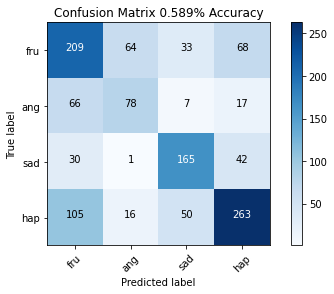



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[153  21  83 117]
 [ 57  36  15  60]
 [ 15   1 190  32]
 [ 93   5  77 259]]


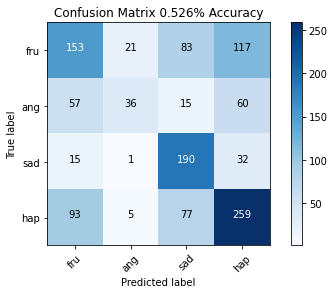

In [14]:
for ses_idx in range(0,5):
    try:
        print(f"-----------------------------------Testing on {ses_idx + 1} fold-----------------------------------")
        val_set = sessions[ses_idx]
        val_pitched_set = pitched_sessions[ses_idx]
        model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
        model = tf.keras.models.load_model(f"{model_folder}/{model_name}")
        print("\n\nNormal Fold:")
        evaluate_model(model, val_set)
        print("\n\nPitched Fold:")
        evaluate_model(model, val_pitched_set)
    except Exception as e:
        print(e)

# Testing 3

-----------------------------------Testing on 1 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[102  60  64  54]
 [ 44 138  15  28]
 [  9   1 175   1]
 [ 26  12  51 185]]


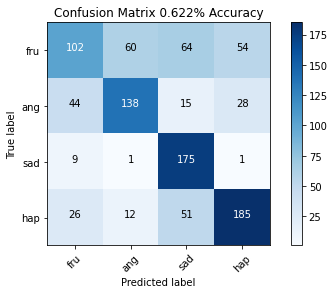



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[108  29  83  60]
 [ 71  78  20  56]
 [  9   0 173   4]
 [ 42   8  54 170]]


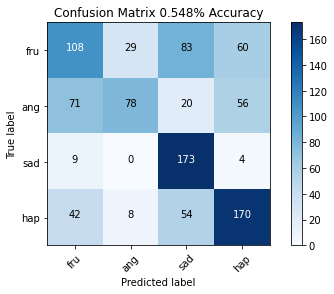

-----------------------------------Testing on 2 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[170  48  26  78]
 [ 37  85   1  14]
 [ 28   0 134  28]
 [ 70  27  20 209]]


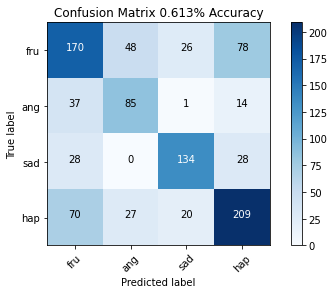



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[157  16  33 116]
 [ 54  40   2  41]
 [ 30   1 134  25]
 [ 82  15  24 205]]


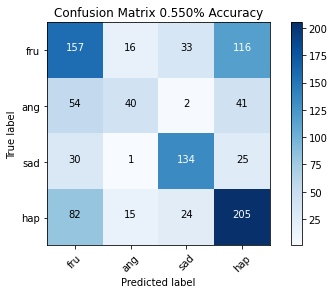

-----------------------------------Testing on 3 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[198  81  43  60]
 [ 88 111   6  34]
 [ 42   4 240  18]
 [ 74  14  78 118]]


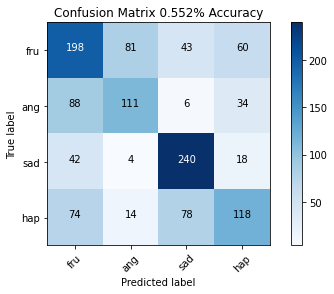



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[169  39  56 118]
 [ 88  70  12  69]
 [ 30   2 260  12]
 [ 56   8  83 137]]


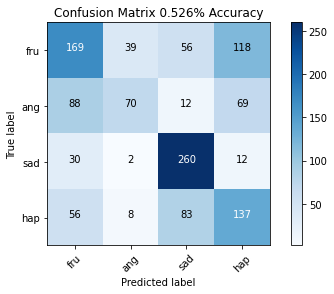

-----------------------------------Testing on 4 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[279 129  28  43]
 [ 88 226   0  11]
 [ 37   4  92   6]
 [ 93  64  21 123]]


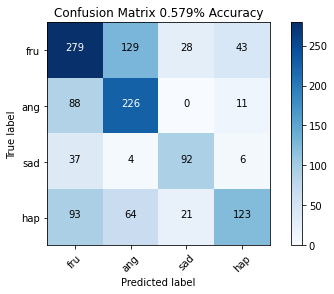



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[266  57  64  92]
 [168 100  10  47]
 [ 19   3 101  16]
 [103  29  28 141]]


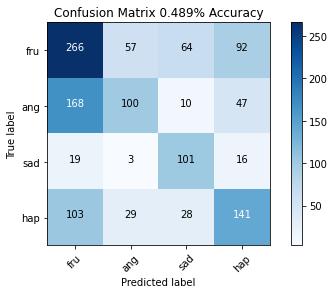

-----------------------------------Testing on 5 fold-----------------------------------


Normal Fold:
Confusion matrix, without normalization
[[209  64  33  68]
 [ 66  78   7  17]
 [ 30   1 165  42]
 [105  16  50 263]]


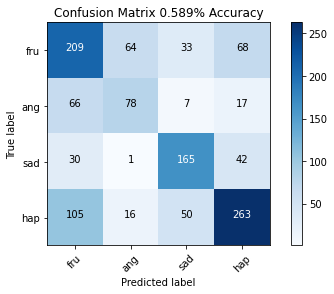



Pitched Fold:


<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)
<ipython-input-5-c592be8d2bf3>:16: FutureWarning: Pass sr=16000, n_steps=-1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data,sample_rate, pitch_factor)


Confusion matrix, without normalization
[[162  30  76 106]
 [ 68  39  14  47]
 [ 15   1 182  40]
 [ 85   8  73 268]]


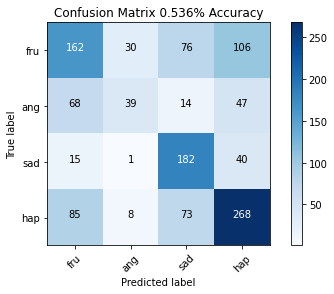

In [15]:
for ses_idx in range(0,5):
    try:
        print(f"-----------------------------------Testing on {ses_idx + 1} fold-----------------------------------")
        val_set = sessions[ses_idx]
        val_pitched_set = pitched_sessions[ses_idx]
        model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
        model = tf.keras.models.load_model(f"{model_folder}/{model_name}")
        print("\n\nNormal Fold:")
        evaluate_model(model, val_set)
        print("\n\nPitched Fold:")
        evaluate_model(model, val_pitched_set)
    except Exception as e:
        print(e)